In [1]:
import json
import os
import ast # For safely evaluating string representations of lists
# Removed 'random' as sampling is no longer used
from pathlib import Path # Use Pathlib for cleaner path handling

# Data analysis and visualization imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm # For accessing color maps

# Jupyter/IPython specific imports
from IPython.display import display # For better rendering of DataFrames

In [7]:
# --- Configuration ---

# Set display options for pandas DataFrames
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Plotting style and settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.tab10.colors) # Use tab10 color cycle

# Define base path (as requested)
user = os.environ.get("USER", "chong032") # Default to chong032 if USER env var not set
BASE_RESULTS_PATH = Path(f"/home/users/ntu/{user}/slimsc/prune/results")

# Define the specific SC runs to analyze for each model and dataset
# Structure: {model_name: {dataset_name: [run_subdirectories]}}
SC_RUNS_TO_ANALYZE = {
    "QwQ-32B": {
        "aime": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
        ],
        "gpqa_diamond": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
        ],
        "aqua_rat": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
        ],
    },
    "R1-Distill-Qwen-14B": {
        "aime": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
        "gpqa_diamond": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
        "aqua_rat": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
    },
}

# Output directory for plots
PLOTS_OUTPUT_DIR = Path(f"/home/users/ntu/{user}/slimsc/prune/visualization/plots")

In [8]:
# --- Helper Function for Full Data Metric Calculation ---

def calculate_metrics_from_full_data(csv_path: Path) -> dict:
    """
    Calculates % Correct Answer Voted (Overall Accuracy) (from mean of final_score),
    % Correct in Individual Answer Candidates
    from the full data in an evaluation_summary.csv.

    Args:
        csv_path: Path to the evaluation_summary.csv file.

    Returns:
        A dictionary containing 'overall_accuracy',
        'perc_correct_in_individual_answers'.
        Returns dict with NaN values if file or data is missing or errors occur.
    """
    results = {
        "overall_accuracy": float("NaN"),
        "perc_correct_in_individual_answers": float("NaN"),
    }

    def clean_answer(ans):
        s = str(ans).strip()
        # Attempt to convert to float if it looks like a number
        try:
            # Using float handles both integers (33 -> 33.0) and floats (33.0 -> 33.0)
            return float(s)
        except ValueError:
             # If not a number, strip common artifacts if it's a letter choice
            if len(s) > 1 and s[0].isalpha() and not s[1].isalnum(): # e.g. "A.", "A)"
                return s[0].upper()
            return s.upper() # General case, convert to upper for case-insensitivity


    if not csv_path.exists():
        print(f"Warning: Evaluation summary file not found at {csv_path}")
        return results
    try:
        df = pd.read_csv(csv_path)
        if df.empty:
            print(f"Warning: {csv_path} is empty.")
            return results

        total_rows = len(df)

        # --- Calculate % Correct Answer Voted (Overall Accuracy) (using final_score mean) ---
        if 'final_score' in df.columns and total_rows > 0:
            try:
                # Convert to numeric, coercing errors to NaN, then calculate the mean
                # Mean of 0s and 1s is the proportion of 1s (accuracy)
                accuracy_from_final_score = pd.to_numeric(df['final_score'], errors='coerce').mean()
                if pd.notna(accuracy_from_final_score):
                     results['overall_accuracy'] = accuracy_from_final_score * 100
                else:
                    print(f"Warning: Final score column in {csv_path.name} contains non-numeric values preventing mean calculation.")
                    print(f"Debug: Overall accuracy set to NaN for {csv_path.name} due to non-numeric final_score.")

            except Exception as e:
                 print(f"Error calculating overall accuracy from final_score mean for {csv_path.name}: {e}")
                 print(f"Debug: Overall accuracy set to NaN for {csv_path.name} due to calculation error.")
        else:
            print(f"Warning: 'final_score' column not found or data is empty in {csv_path.name}. Cannot calculate overall accuracy.")
            print(f"Debug: Overall accuracy set to NaN for {csv_path.name} due to missing column or empty data.")


        # --- Calculate % Correct in Individual Answer Candidates ---
        correct_present_count = 0
        total_rows_parsable_individual = 0

        if 'individual_answers_str' in df.columns and 'correct_answer' in df.columns:
             for _, row in df.iterrows():
                try:
                    # Use the clean_answer function defined above
                    current_correct_answer_cleaned = clean_answer(row['correct_answer'])

                    individual_answers_str = row['individual_answers_str']

                    if pd.isna(individual_answers_str) or not str(individual_answers_str).strip():
                        individual_answers_list_cleaned = []
                    else:
                        raw_list = ast.literal_eval(str(individual_answers_str))
                        # Clean every answer in the individual list
                        individual_answers_list_cleaned = [clean_answer(ans) for ans in raw_list]

                    if current_correct_answer_cleaned in individual_answers_list_cleaned:
                        correct_present_count += 1
                    total_rows_parsable_individual += 1

                except (SyntaxError, ValueError) as e:
                     # print(f"Warning: Could not parse individual_answers_str in data from {csv_path.name} for iteration: {row.get('iteration', 'N/A')}. Error: {e}")
                     pass # Suppress excessive warnings; rows with errors won't count towards the denominator for this metric
                except Exception as e:
                    print(f"Warning: Error processing row for individual answers in {csv_path.name} for iteration: {row.get('iteration', 'N/A')}: {e}")

             if total_rows_parsable_individual > 0:
                  results['perc_correct_in_individual_answers'] = (correct_present_count / total_rows_parsable_individual) * 100
             # else: It remains NaN from initialization if no rows were parsable
             else:
                 print(f"Debug: Individual percentage set to NaN for {csv_path.name} due to 0 parsable rows.")
        else:
            print(f"Warning: Missing 'individual_answers_str' or 'correct_answer' for individual answer calculation in {csv_path.name}")


        # # --- Calculate Voting Efficiency ---
        # acc = results.get('overall_accuracy')
        # perc_ind = results.get('perc_correct_in_individual_answers')

        # # Check if both values are numeric and valid (handle potential NaNs from previous steps)
        # if pd.notna(acc) and pd.notna(perc_ind):
        #      if perc_ind > 0:
        #           results['voting_efficiency'] = acc / perc_ind * 100 # Efficiency is ratio of percentages
        #      else:
        #           # If %_ind is 0, efficiency is 0.
        #           results['voting_efficiency'] = 0.0
        # else:
        #      print(f"Debug: Efficiency set to NaN for {csv_path.name} because accuracy ({acc}) or individual percentage ({perc_ind}) was NaN.")


    except FileNotFoundError:
        print(f"Error: File not found at {csv_path}")
    except pd.errors.EmptyDataError:
        print(f"Error: No data in file {csv_path}")
    except Exception as e:
        print(f"An unexpected error occurred while processing {csv_path}: {e}")
        
    return results

In [9]:
# --- Data Collection ---

all_sc_data = []

print("--- Starting Data Collection for SC Runs (Full Data) ---")

for model, datasets in SC_RUNS_TO_ANALYZE.items():
    print(f"\nProcessing model: {model}")
    for dataset, run_names in datasets.items():
        print(f"  Processing dataset: {dataset}")
        for run_name in run_names:
            print(f"    Processing run: {run_name}...")
            run_path = BASE_RESULTS_PATH / model / dataset / run_name
            eval_summary_path = run_path / "evaluation_summary.csv"

            # Extract n_chains from run name
            # Example: "sc_16_control" -> 16
            try:
                parts = run_name.split('_')
                if len(parts) >= 2 and parts[0] == 'sc':
                    n_chains = int(parts[1])
                else:
                    print(f"Warning: Could not extract n_chains from run name: {run_name}. Skipping.")
                    continue
            except PercentageError:
                 print(f"Warning: Could not parse n_chains from run name: {run_name}. Skipping.")
                 continue

            # Calculate metrics from full data
            metrics = calculate_metrics_from_full_data(eval_summary_path)

            # Append results
            run_data = {
                "Model": model,
                "Dataset": dataset,
                "n_chains": n_chains,
                "% Correct Answer Voted (Overall Accuracy)": metrics.get("overall_accuracy", float("NaN")),
                "% Correct Answer Present in Final Candidates": metrics.get("perc_correct_in_individual_answers", float("NaN")),
            }
            all_sc_data.append(run_data)
            # print(f"      Collected data: {run_data}") # Uncomment for detailed logging

print("\n--- Finished Data Collection ---")

--- Starting Data Collection for SC Runs (Full Data) ---

Processing model: QwQ-32B
  Processing dataset: aime
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
  Processing dataset: gpqa_diamond
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_control...
  Processing dataset: aqua_rat
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_control...

Processing model: R1-Distill-Qwen-14B
  Processing dataset: aime
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_control...
    Processing run: sc_64_control...
  Processing dataset: gpqa_diamond
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_con

In [10]:
# --- Data Structuring and Display ---

df_sc = pd.DataFrame(all_sc_data)

if not df_sc.empty:
    # Sort by n_chains for consistent plotting order
    df_sc = df_sc.sort_values(by=['Model', 'Dataset', 'n_chains']).reset_index(drop=True)

    print("\nFull Data SC Metrics Summary:")
    display(df_sc.style.format({
        "% Correct Answer Voted (Overall Accuracy)": "{:.2f}%",
        "% Correct Answer Present in Final Candidates": "{:.2f}%",
    }, na_rep="N/A"))

    # Melt the DataFrame for plotting
    df_sc_melted = df_sc.melt(
        id_vars=['Model', 'Dataset', 'n_chains'],
        value_vars=['% Correct Answer Voted (Overall Accuracy)', '% Correct Answer Present in Final Candidates'],
        var_name='Metric',
        value_name='Percentage'
    )

    # Add a column to distinguish between percentage metrics and efficiency for formatting
    def get_format_type(metric_name):
        if '%' in metric_name:
            return 'percentage'
        else:
            return 'efficiency'

    df_sc_melted['MetricType'] = df_sc_melted['Metric'].apply(get_format_type)

else:
    print("\nNo data collected for SC experiments.")


Full Data SC Metrics Summary:


,Model,Dataset,n_chains,% Correct Answer Voted (Overall Accuracy),% Correct Answer Present in Final Candidates
0,QwQ-32B,aime,2,80.00%,90.00%
1,QwQ-32B,aime,8,86.21%,86.21%
2,QwQ-32B,aime,16,83.33%,93.33%
3,QwQ-32B,aqua_rat,2,92.13%,92.91%
4,QwQ-32B,aqua_rat,8,91.73%,93.70%
5,QwQ-32B,aqua_rat,16,91.34%,93.70%
6,QwQ-32B,aqua_rat,32,91.73%,94.49%
7,QwQ-32B,gpqa_diamond,2,62.12%,70.20%
8,QwQ-32B,gpqa_diamond,8,65.15%,81.31%
9,QwQ-32B,gpqa_diamond,16,68.18%,82.83%



--- Generating Plots ---
  Generating plot for QwQ-32B / aime...
    Saved plot to /home/users/ntu/chong032/slimsc/prune/visualization/plots/QwQ-32B_aime_sc_ideal_vs_actual_acc.png


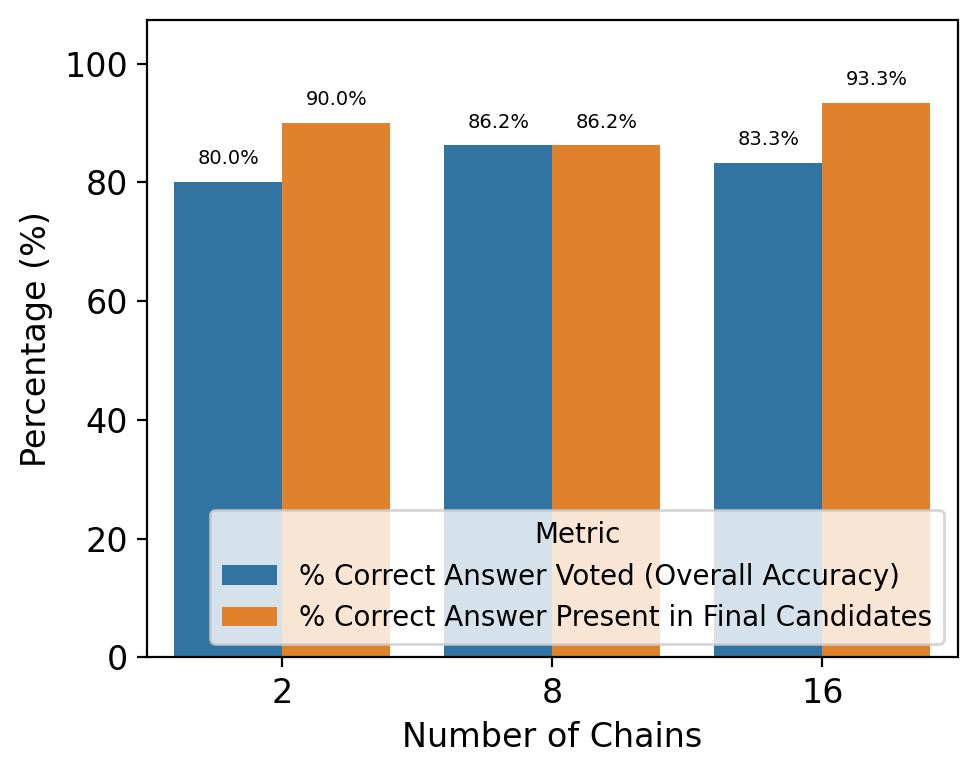

  Generating plot for QwQ-32B / aqua_rat...
    Saved plot to /home/users/ntu/chong032/slimsc/prune/visualization/plots/QwQ-32B_aqua_rat_sc_ideal_vs_actual_acc.png


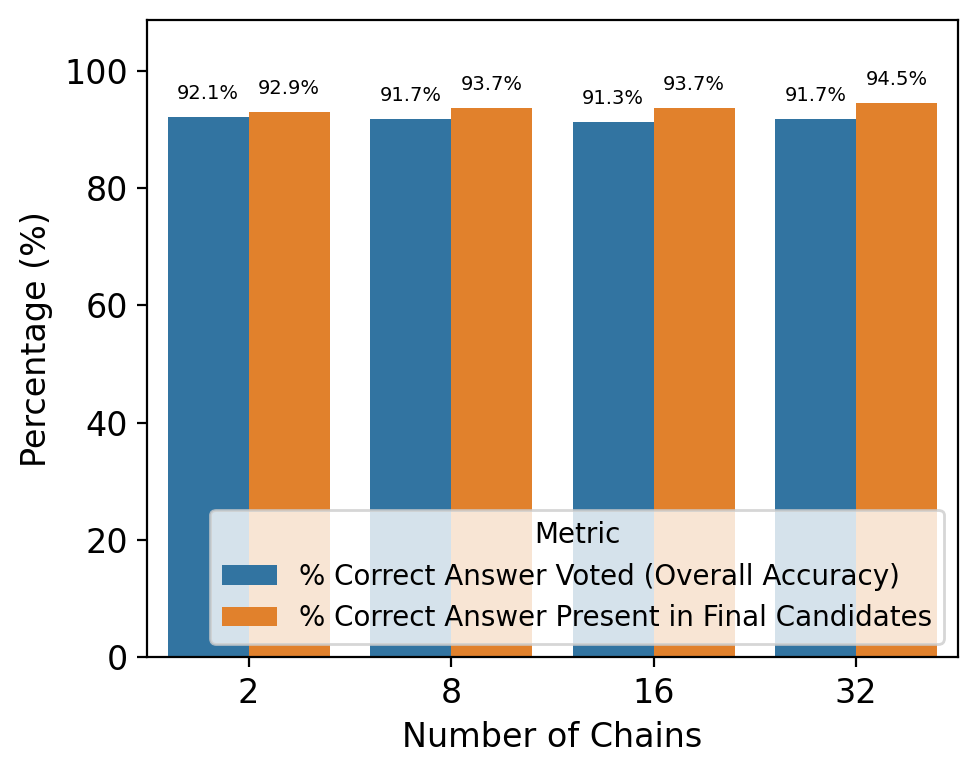

  Generating plot for QwQ-32B / gpqa_diamond...
    Saved plot to /home/users/ntu/chong032/slimsc/prune/visualization/plots/QwQ-32B_gpqa_diamond_sc_ideal_vs_actual_acc.png


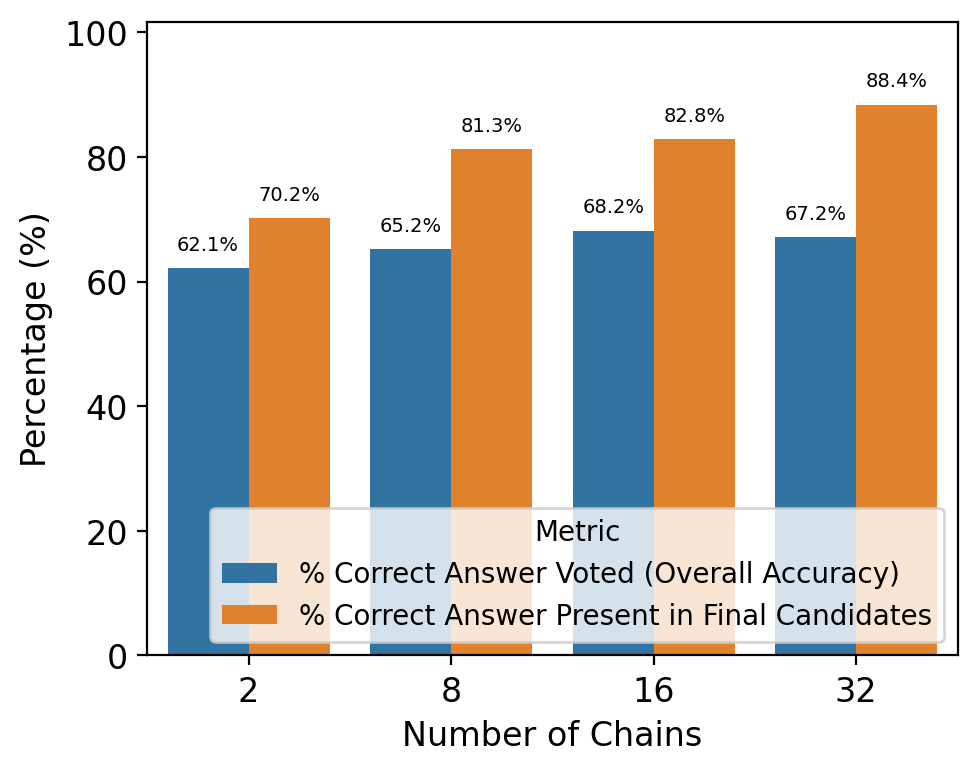

  Generating plot for R1-Distill-Qwen-14B / aime...
    Saved plot to /home/users/ntu/chong032/slimsc/prune/visualization/plots/R1-Distill-Qwen-14B_aime_sc_ideal_vs_actual_acc.png


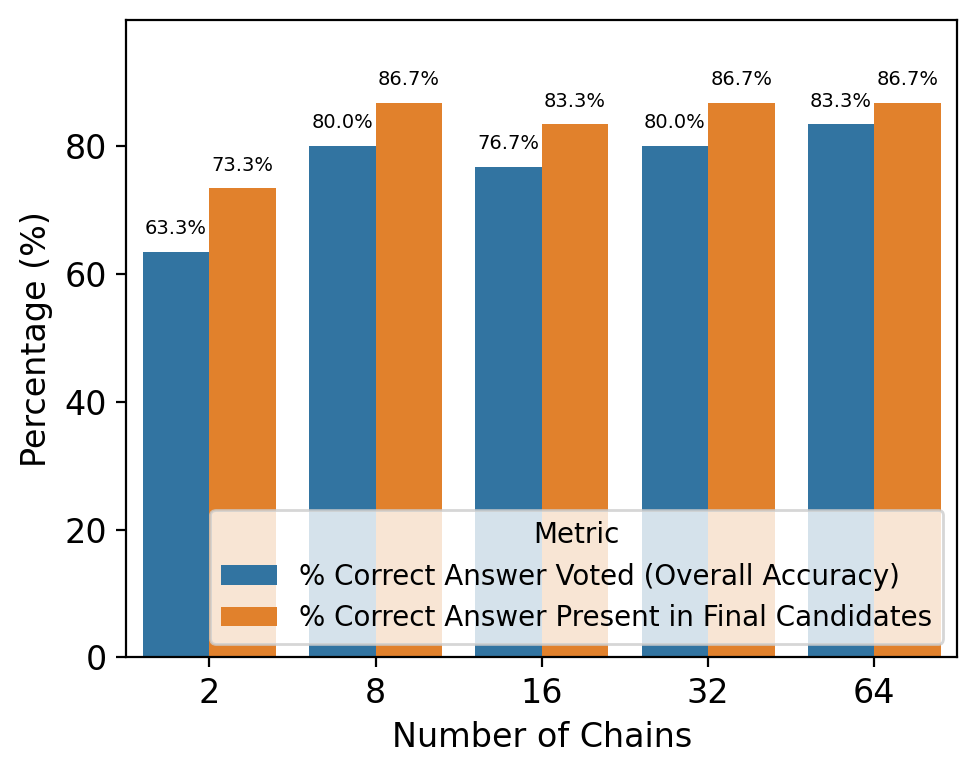

  Generating plot for R1-Distill-Qwen-14B / aqua_rat...
    Saved plot to /home/users/ntu/chong032/slimsc/prune/visualization/plots/R1-Distill-Qwen-14B_aqua_rat_sc_ideal_vs_actual_acc.png


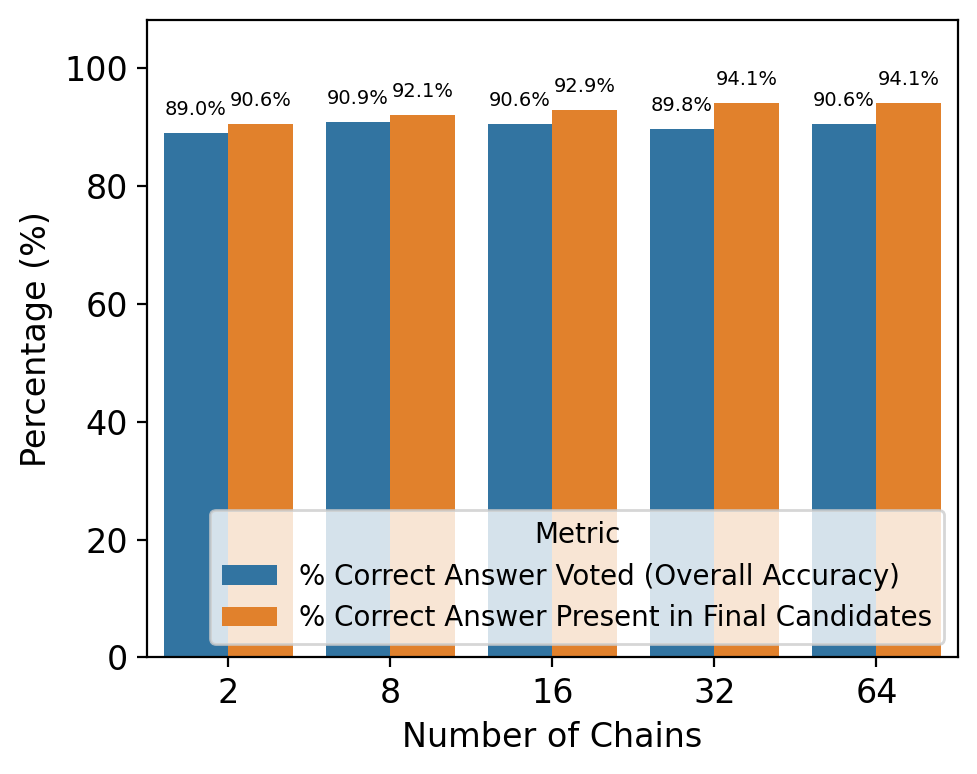

  Generating plot for R1-Distill-Qwen-14B / gpqa_diamond...
    Saved plot to /home/users/ntu/chong032/slimsc/prune/visualization/plots/R1-Distill-Qwen-14B_gpqa_diamond_sc_ideal_vs_actual_acc.png


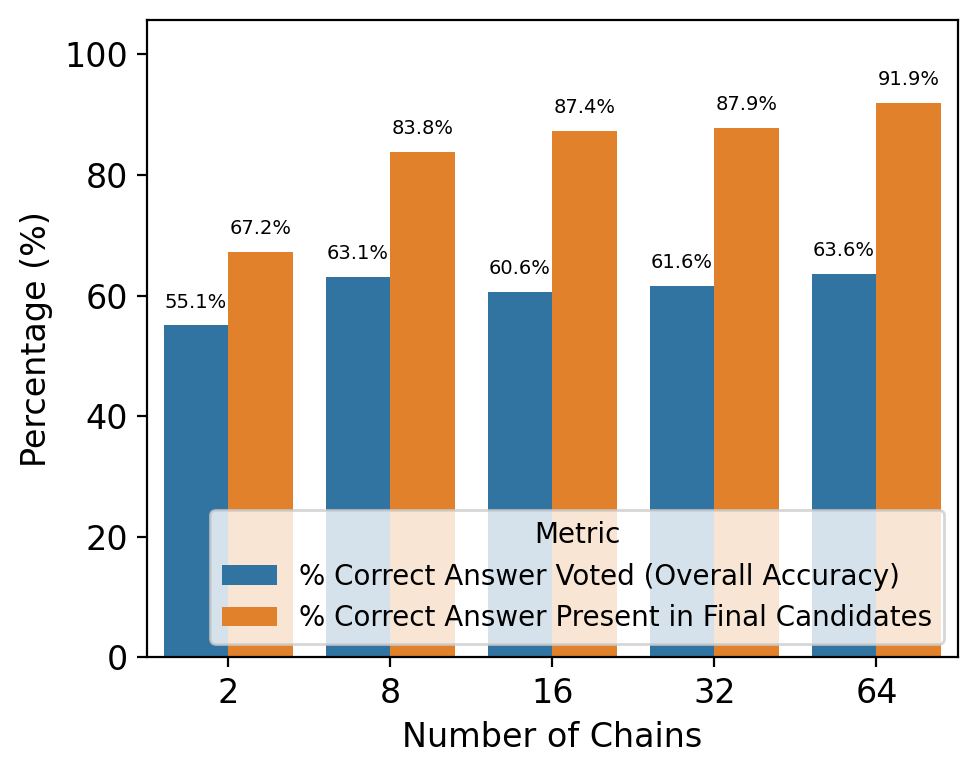


--- Plotting Complete ---


In [12]:
# --- Plotting ---

if not df_sc_melted.empty:
    print("\n--- Generating Plots ---")

    # Iterate through each Model/Dataset combination
    for (model, dataset), group_df in df_sc_melted.groupby(['Model', 'Dataset']):
        print(f"  Generating plot for {model} / {dataset}...")

        # Ensure n_chains is treated correctly for plotting order
        group_df = group_df.sort_values(by='n_chains')

        plt.figure(figsize=(5, 4)) # Adjust figure size as needed

        # Use seaborn.barplot for grouped bars
        ax = sns.barplot(
            x='n_chains',
            y='Percentage',
            hue='Metric',
            data=group_df,
            palette='tab10' # You can choose a different palette
        )

        # Add title and labels
        plt.xlabel('Number of Chains', fontsize=12)
        plt.ylabel('Percentage (%)', fontsize=12) # Generic label as y-axis scale varies by metric type

        # Add value annotations to bars
        # Iterate over the containers of bars for each hue level (Metric)
        for container in ax.containers:
            # Get the metric name for this container from its label
            # get_label() works well if you used `hue=...` with a DataFrame column name
            metric_name = container.get_label()
            metric_type = get_format_type(metric_name) # Get the type for formatting

            # Iterate over the patches (bars) within this container
            # The patches are ordered according to the x-axis categories (n_chains)
            for patch in container.patches:
                height = patch.get_height()

                # Only annotate if the value is not NaN
                if pd.notna(height):
                    # Determine the text based on metric type
                    annotation_text = f"{height:.1f}%"

                    # Place the annotation slightly above the center of the bar
                    x_pos = patch.get_x() + patch.get_width() / 2. # Center of the bar
                    y_pos = height # Top of the bar

                    ax.annotate(annotation_text,
                                (x_pos, y_pos),
                                ha = 'center', # Center horizontally
                                va = 'bottom', # Align vertically from the bottom of the text
                                xytext = (0, 5), # Offset text 5 points upwards
                                textcoords = 'offset points',
                                fontsize=7)


        # Improve layout
        plt.xticks(rotation=0, fontsize=12) # No rotation needed for small number of chains
        plt.yticks(fontsize=12)
        plt.legend(title='Metric', loc='lower right')

        # Adjust y-axis limits for clarity
        max_val = group_df['Percentage'].max()
        plt.ylim(0, max_val * 1.15 if pd.notna(max_val) else 1) # Add 15% padding above max value


        plt.tight_layout()

        # Save the plot
        plot_filename = f"{model.replace('/', '_')}_{dataset}_sc_ideal_vs_actual_acc.png"
        plot_path = PLOTS_OUTPUT_DIR / plot_filename
        plt.savefig(plot_path, dpi=300)
        print(f"    Saved plot to {plot_path}")

        plt.show()
else:
    print("\nNo data to plot.")

print("\n--- Plotting Complete ---")